In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pylab as pylab
import geopandas as gpd
plt.style.use('ggplot')

In [69]:
# load the data
cases_raw = pd.read_csv('data/line-list-nigeria.csv')
health_raw = pd.read_csv('data/healthmopupandbaselinenmisfacility.csv')
pop_raw = pd.read_csv('data/nga_pop_adm1_2016.csv')

In [70]:
# make some copies
cases = cases_raw.copy()
pop = pop_raw.copy()
health = health_raw.copy()

In [71]:
# most columns contain little useful information and are empty. keep only the useful stuff
cases = cases[['case_id', 'date', 'province/state']]

In [72]:
# date is an object, convert to datetime
cases['date_dt'] = pd.to_datetime(cases['date'])

In [99]:
# do some useful aggregations - group by day and week on national and state level
daily_state = cases.groupby('province/state').resample('D', on='date_dt')['case_id'].count().reset_index(name='cases')
weekly_state = cases.groupby('province/state').resample('W-Mon', on='date_dt')['case_id'].count().reset_index(name='cases')

daily = cases.resample('D', on='date_dt')['case_id'].count().reset_index(name='cases')
daily['7_day_avg'] = daily.rolling(window=7).mean()
weekly = cases.resample('W-Mon', on='date_dt')['case_id'].count().reset_index(name='cases')

# also get the total cases for each state
cases_by_state = weekly_state.groupby('province/state')['province/state','cases'].sum()

In [101]:
weekly_state

,province/state,date_dt,cases
0,Abia,2020-04-20,2
1,Abia,2020-04-27,0
2,Abia,2020-05-04,0
3,Abia,2020-05-11,0
4,Abia,2020-05-18,3
...,...,...,...
231,Yobe,2020-05-18,19
232,Zamfara,2020-04-27,2
233,Zamfara,2020-05-04,11
234,Zamfara,2020-05-11,60


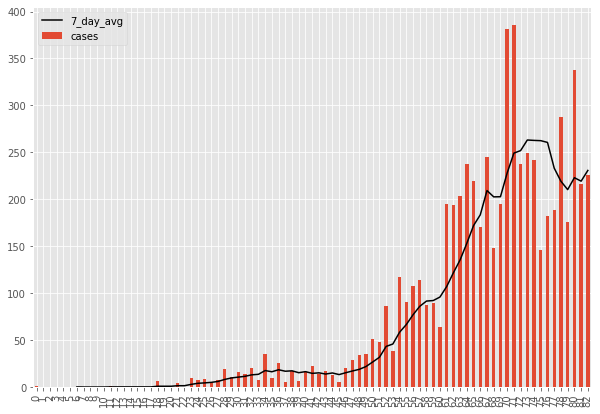

In [96]:
# quick and dirty plot of daily cases and the 7 day rolling average
fig, ax = plt.subplots(figsize=(10,7))

daily.plot(y=['7_day_avg'], kind='line', ax=ax, c='k')
daily.plot(y=['cases'], kind='bar', ax=ax, stacked=True)

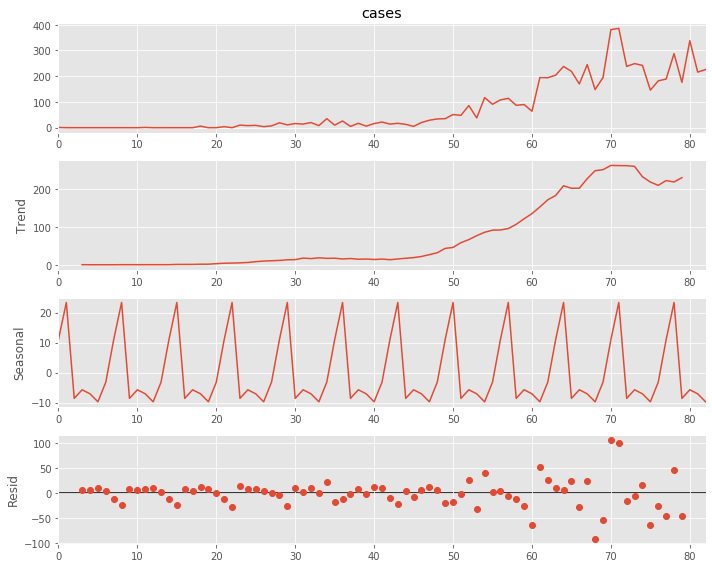

In [75]:
# check for any trends. overall increasing - small seasonal component (e.g. from inconsistent reporting) is small. 
pylab.rcParams['figure.figsize'] = (10, 8)

res = sm.tsa.seasonal_decompose(daily['cases'],period=7)
resplot = res.plot()

In [76]:
pop = pop[['admin1Name_en', 'Unnamed: 1', 'Unnamed: 4']].rename(columns={'Unnamed: 1': 'state_code', 'Unnamed: 4': 'population'})

In [82]:
# join the weekly data with population. calculate a case rate per population.
weekly_state_pop = weekly_state.set_index('province/state').join(
                    pop[['admin1Name_en', 'population']].set_index('admin1Name_en')
                    ).reset_index().rename(columns={'index': 'province/state'})

In [83]:
weekly_state_pop['case_rate_1M'] = (weekly_state_pop['cases']/weekly_state_pop['population'])*1000000

In [84]:
weekly_state_pop.drop(columns='population')

,province/state,date_dt,cases,case_rate_1M
0,Abia,2020-04-20,2,0.548740
1,Abia,2020-04-27,0,0.000000
2,Abia,2020-05-04,0,0.000000
3,Abia,2020-05-11,0,0.000000
4,Abia,2020-05-18,3,0.823110
...,...,...,...,...
231,Yobe,2020-05-18,19,5.942521
232,Zamfara,2020-04-27,2,0.456943
233,Zamfara,2020-05-04,11,2.513188
234,Zamfara,2020-05-11,60,13.708298


In [85]:
# do the same for the national data - will be useful to see which states are above/below national averages
weekly['case_rate_1M'] = (weekly['cases']/pop['population'].sum())*1000000

In [86]:
weekly

,date_dt,cases,case_rate_1M
0,2020-03-02,1,0.005325
1,2020-03-09,1,0.005325
2,2020-03-16,6,0.031952
3,2020-03-23,31,0.165084
4,2020-03-30,91,0.484601
5,2020-04-06,107,0.569806
6,2020-04-13,107,0.569806
7,2020-04-20,321,1.709417
8,2020-04-27,671,3.573268
9,2020-05-04,1465,7.801546
